In [273]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
import toolbox as tbx

In [275]:
import os
import dateutil

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [276]:
data_directory = os.path.join(os.getenv("HOME"), 'Research/data/ENA')

uhsas_directory = os.path.join(data_directory, 'uhsas/aos')
sfmet_directory = os.path.join(data_directory, 'met')

In [277]:
UHSAS = tbx.fileIO.NetCDFFolder(uhsas_directory)
SFMET = tbx.fileIO.NetCDFFolder(sfmet_directory)

In [278]:
UHSAS.summary()
SFMET.summary()

/Users/jstemm/Research/data/ENA/uhsas/aos
Found 543 files total
 > Found 543 items for datastream enaaosuhsasC1

/Users/jstemm/Research/data/ENA/met
Found 697 files total
 > Found 697 items for datastream enametC1



In [279]:
uhsas_file = np.random.choice(UHSAS.filelist)

dstr = uhsas_file.split('.')[2]
dtime = dateutil.parser.parse(dstr)

sfmet_files = SFMET.filelist[np.array([dstr in f for f in SFMET.filelist])].tolist()

sfmet = pd.concat([tbx.fileIO.NetCDFFile(f)
                   .get_vars(varlist=['wdir_vec_mean', 'wspd_vec_mean'],
                             exclude='qc')
                   .astype(np.float)
                   for f in sfmet_files])

(8639, 99)


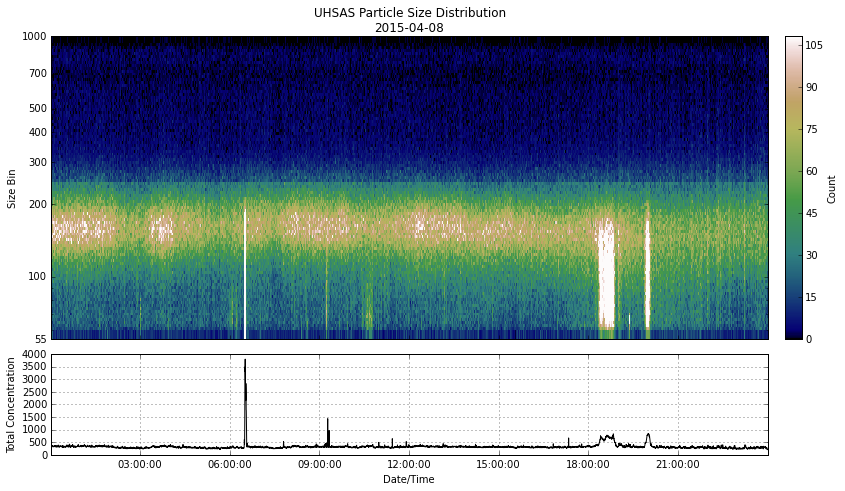

In [280]:
uhsas = tbx.fileIO.UHSAS(uhsas_file)
print(uhsas.size_distribution.shape)
fig, ax = uhsas.plot(cmap = cm.gist_earth)

<matplotlib.colorbar.Colorbar instance at 0x11bff3cb0>

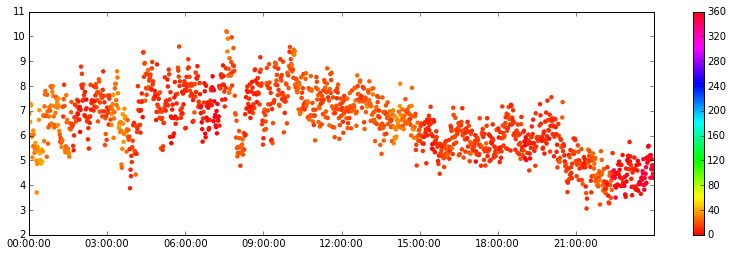

In [281]:
fig, ax = plt.subplots(figsize=(14, 4))
sc = ax.scatter(sfmet.index, sfmet.wspd_vec_mean, 
           c=sfmet.wdir_vec_mean, cmap=cm.hsv,
           edgecolor='none',
           vmin=0, vmax=360)
ax.set_xlim(sfmet.index[0], sfmet.index[-1])

fig.colorbar(sc)

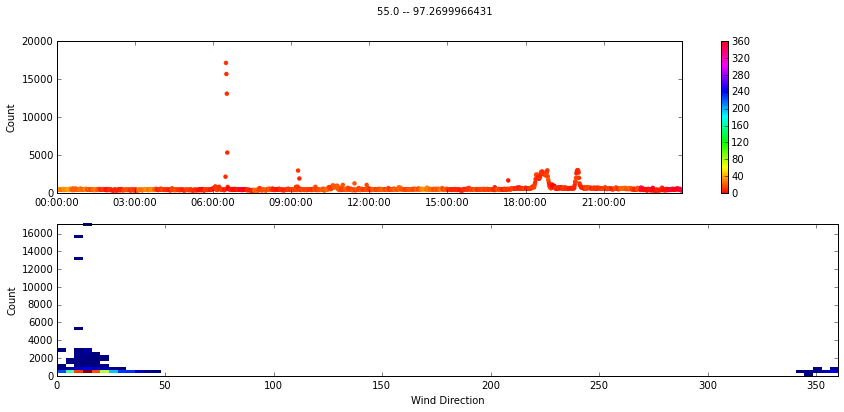

In [282]:
sbin = (0, 19)

size_mask = uhsas.upper_size_limit < 100
lower_bound = uhsas.lower_size_limit[size_mask]
upper_bound = uhsas.upper_size_limit[size_mask]

concentration = uhsas.size_distribution[:, size_mask].sum(axis=1)

data = (pd.DataFrame({'size_distribution': uhsas.size_distribution[:, sbin[0]:sbin[1]].sum(axis=1)}, 
                     index=uhsas.datetimes)
        .resample('1Min').join(sfmet.wdir_vec_mean))

fig, (ax, bx) = plt.subplots(2, figsize=(14, 6))
fig.suptitle('{} -- {}'.format(lower_bound[0], upper_bound[-1]))

sc = ax.scatter(data.index, data.size_distribution, 
                c=data.wdir_vec_mean, edgecolor='none', 
                cmap=cm.hsv,
                vmin=0, vmax=360)
ax.set_xlim(data.index[0], data.index[-1])
ax.set_ylabel('Count')
ax.set_ylim(bottom=0)
fig.colorbar(sc, ax=ax)

h = bx.hist2d(data.wdir_vec_mean, data.size_distribution, 
              bins=[90, 50], cmin=1, range=[[0, 360], [0, np.max(data.size_distribution)]])
bx.set_xlabel('Wind Direction')
bx.set_ylabel('Count')
#bx.set_xlim(0, 360)